# Retention Scoring - PROD - Redshift - ALL NHL Data
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* July 14, 2022

## Hypothesis
This notebook will test the retention model features and the goal is to check how the accuracy and scores look when we train the model only with Canucks data compared to all NHL data.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [74]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import psycopg2
from shared_utilities import helpers
from pycaret.classification import *

In [75]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

DCGL-WZTC
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [76]:
teams = [{'lkupclientid': 7, 'clientcode': 'canucks', 'stlrDBName': 'stlrcanucks'},
         {'lkupclientid': 33, 'clientcode': 'vgk', 'stlrDBName': 'stlrvgk'},
         {'lkupclientid': 36, 'clientcode': 'flames', 'stlrDBName': 'stlrflames'},
         {'lkupclientid': 55, 'clientcode': 'coyotes', 'stlrDBName': 'stlrcoyotes'},
         {'lkupclientid': 93, 'clientcode': 'nhlpanthers', 'stlrDBName': 'stlrnhlpanthers'}]

all_data = []
for team in teams:
    conn = helpers.get_redshift_connection('prod-app', team['stlrDBName'])
    
    # call the stored proc to get data for the product propensity model
    cur = conn.cursor()
    cur.execute(f"CALL {team['stlrDBName']}.ds.getretentionmodeldata({team['lkupclientid']},2010, 2022, 'temp_cursor')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn.cursor('temp_cursor')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df = pd.DataFrame(data=data, columns=cols)
    all_data.append(df)
    
    conn.commit()

    

In [77]:
dfObj = pd.DataFrame(columns=["lkupclientid",
    "dimcustomermasterid",
    "year", 
    "productgrouping",
    "recentdate",
    "attendancepercent",
    "recency",
    "source_tenure",
    "totalspent",
    "isnextyear_buyer"])

In [78]:
for data in all_data:
    dfObj= dfObj.append(data)
dfObj.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,recentdate,attendancepercent,recency,source_tenure,totalspent,isnextyear_buyer,...,missed_games_1,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact
0,7,7556,2017,Quarter,2018-03-31 00:00:00,1.0,0,4380,2134.76,1,...,0,0,0,0.0,3.79,0.42,0.11,Male,0.0,0.0
1,7,17087,2019,Quarter,2020-03-04 00:00:00,0.8,0,5475,2670.6,0,...,2,0,0,0.0,1.68,0.52,0.31,Unknown,0.0,0.0
2,7,19065,2021,Full Season,2022-02-19 00:00:00,0.06,15,12410,10815.2,1,...,0,0,3,24.0,4.23,0.13,0.03,Unknown,0.0,0.0
3,7,4891,2019,Quarter,2020-03-04 00:00:00,0.9,0,1095,2135.7,0,...,1,0,0,0.0,2.72,0.38,0.14,Unknown,0.0,0.0
4,7,7961,2017,Full Season,2018-04-05 00:00:00,0.63,0,12410,13135.5,1,...,5,1,3,0.0,0.81,0.01,0.01,Unknown,0.0,0.0


In [79]:
dfObj['lkupclientid'].unique()

array([7, 33, 36, 55, 93], dtype=object)

In [80]:
# choose the features for the stellar base retention model
features = [
    "lkupclientid",
    "dimcustomermasterid",
    "year", 
    "productgrouping",
    "recentdate",
    "attendancepercent",
    "recency",
    "source_tenure",
    "totalspent",
    "isnextyear_buyer"
]

# copy your main dataframe
df_dataset = dfObj

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2020]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (89202, 10)
Unseen Data For Predictions: (1774, 10)



In [81]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimcustomermasterid",
        "lkupclientid",
        "productgrouping",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
        "recency",
        "source_tenure",
        "totalspent"
    ]
);

In [82]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8275,0.8954,0.8890,0.8217,0.8540,0.6440,0.6471,2.7480


In [83]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8341,0.9010,0.8929,0.8282,0.8593,0.6579,0.6606
1,0.8289,0.9003,0.8878,0.8244,0.8549,0.6472,0.6499
2,0.8218,0.8933,0.8787,0.8202,0.8485,0.6329,0.6351
3,0.8237,0.8916,0.8882,0.8171,0.8512,0.6358,0.6391
4,0.8322,0.8981,0.8954,0.8242,0.8584,0.6535,0.6569
5,0.8281,0.8944,0.8913,0.8212,0.8548,0.6451,0.6484
6,0.8225,0.8884,0.8810,0.8197,0.8493,0.6340,0.6365
7,0.8238,0.8912,0.8931,0.8144,0.8520,0.6355,0.6396
8,0.8310,0.9017,0.8938,0.8236,0.8572,0.6512,0.6544
9,0.8289,0.8945,0.8880,0.8242,0.8549,0.6473,0.6499


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

In [84]:
df_inference_year = dfObj.loc[dfObj["year"] >= 2021]
df_inference = df_inference_year.loc[df_inference_year["lkupclientid"] == 7]
df_inference = df_inference.fillna(0)
df_inference.shape

(5143, 23)

In [85]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,recentdate,attendancepercent,recency,source_tenure,totalspent,isnextyear_buyer,...,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,Label,Score_0,Score_1
2,7,19065,2021,Full Season,2022-02-19,0.06,15,12410,10815.2,1,...,24.0,4.23,0.13,0.03,Unknown,0.0,0.0,1,0.1446,0.8554
8,7,46677,2021,Quarter,2022-04-14,1.00,0,6570,1578.5,0,...,0.0,3.95,0.33,0.08,Unknown,0.0,0.0,1,0.3185,0.6815
10,7,49754,2021,Half Season,2022-04-26,0.50,0,730,4692.4,0,...,10.0,1.81,0.71,0.39,Unknown,0.0,0.0,1,0.3694,0.6306
15,7,73433,2021,Quarter,2022-04-03,0.56,0,1460,4347.0,0,...,4.0,3.71,0.33,0.09,Unknown,0.0,0.0,1,0.3735,0.6265
36,7,11760,2021,Full Season,2022-04-14,0.20,2,365,7925.4,1,...,36.0,0.00,0.00,0.00,Unknown,0.0,0.0,1,0.2502,0.7498


In [86]:
new_predictions["Label"].value_counts()

1    3934
0    1209
Name: Label, dtype: int64

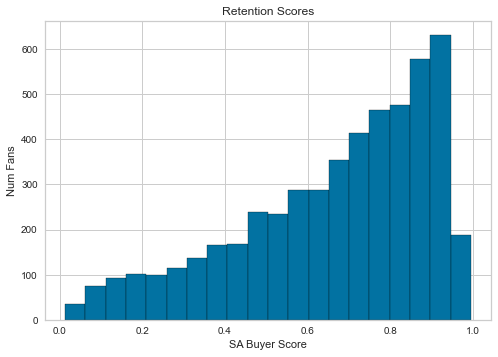

In [87]:
plt.hist(new_predictions["Score_1"], bins=20, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

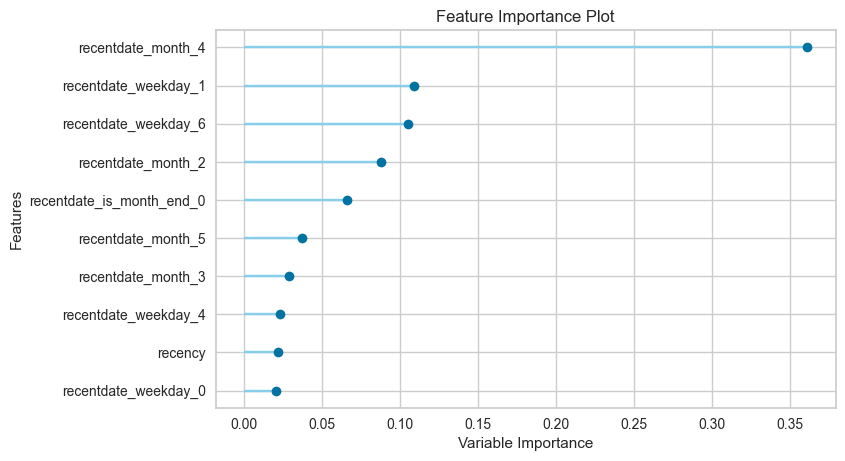

In [88]:
plot_model(final_model, plot='feature')

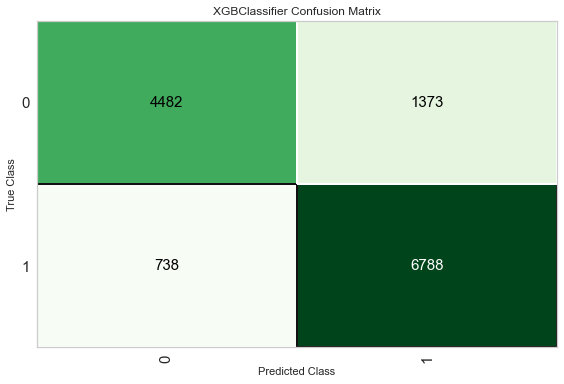

In [89]:
plot_model(final_model, plot='confusion_matrix')

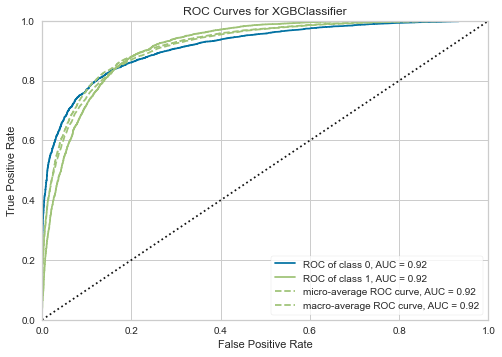

In [90]:
plot_model(final_model, plot='auc')

In [91]:
report = ProfileReport(new_predictions)
report.to_file("NHL_data_retention_predictions.html")

Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [92]:
report2 = ProfileReport(df)
report2.to_file("NHL_data_retention_df.html")

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Observations for using all NHL data

1. How accurate was this model? 
* The accuracy is 84% (3% more than using canucks data)

2. How many fans will buy ticket for 2022 season?
* 905 fans out of 5143 (676 fans more than using canucks data)

3. What were the most important features in making a correct prediction?
* recentdate_month_4, recentdate_is_month_end_0, recentdate_weekday_1 are top 3 important features.


### Done